In [1]:
import pickle
import pandas as pd
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [18]:
phrog_palette = {
    'DNA, RNA and nucleotide metabolism': 'red',
    'connector': 'blue',
    'head and packaging': 'green',
    'integration and excision': 'pink',
    'lysis': 'gray',
    'moron, auxiliary metabolic gene and host takeover': 'brown',
    'other': 'purple',
    'tail': 'darkorange',
    'transcription regulation': 'cyan'
}

### load vector similarities and alignment scores for each family

In [2]:
tps = []
for ph in os.listdir('phrog_pdist/'):
    p = ph.split('.')[0]
    x = pickle.load(open('phrog_pdist/{0}' ''.format(ph), 'rb'))
    m = np.mean(x[np.triu_indices(n=len(x), k=1)])
    s = np.std(x[np.triu_indices(n=len(x), k=1)])
    
    tps.append((p, m, s, len(x)))

df = pd.DataFrame(tps, columns=['#phrog', 'mean_vector_sim', 'sd_vector_sim', 'num_sequences'])

In [3]:
pairwise_mean = pickle.load(open('phrog_mean_pairwise_align_dist.pkl', 'rb'))
pairwise_std = pickle.load(open('phrog_std_pairwise_align_dist.pkl', 'rb'))

In [4]:
df['pairwise_mean'] = [pairwise_mean[p] if p in pairwise_mean else np.nan for p in df['#phrog']]

In [5]:
df['pairwise_std'] = [pairwise_std[p] if p in pairwise_std else np.nan for p in df['#phrog']]

In [7]:
df = df[~df['pairwise_mean'].isna()]
df_a = df[df['pairwise_mean'] < 0.99]

### limit to only categories of interest

In [19]:
phrog_metadata = pd.read_csv('/Users/zacharyflamholz/Desktop/IMAC_local/PHROG/PHROG_data/PHROG_index_revised_v4_10292022.csv')

In [20]:
df_b = phrog_metadata.merge(right=df_a, how='inner', on='#phrog')
df_b = df_b[~df_b['Category'].isin(['unknown function'])]
df_b.sort_values(by='Category', inplace=True)

In [28]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams['font.size'] = 14

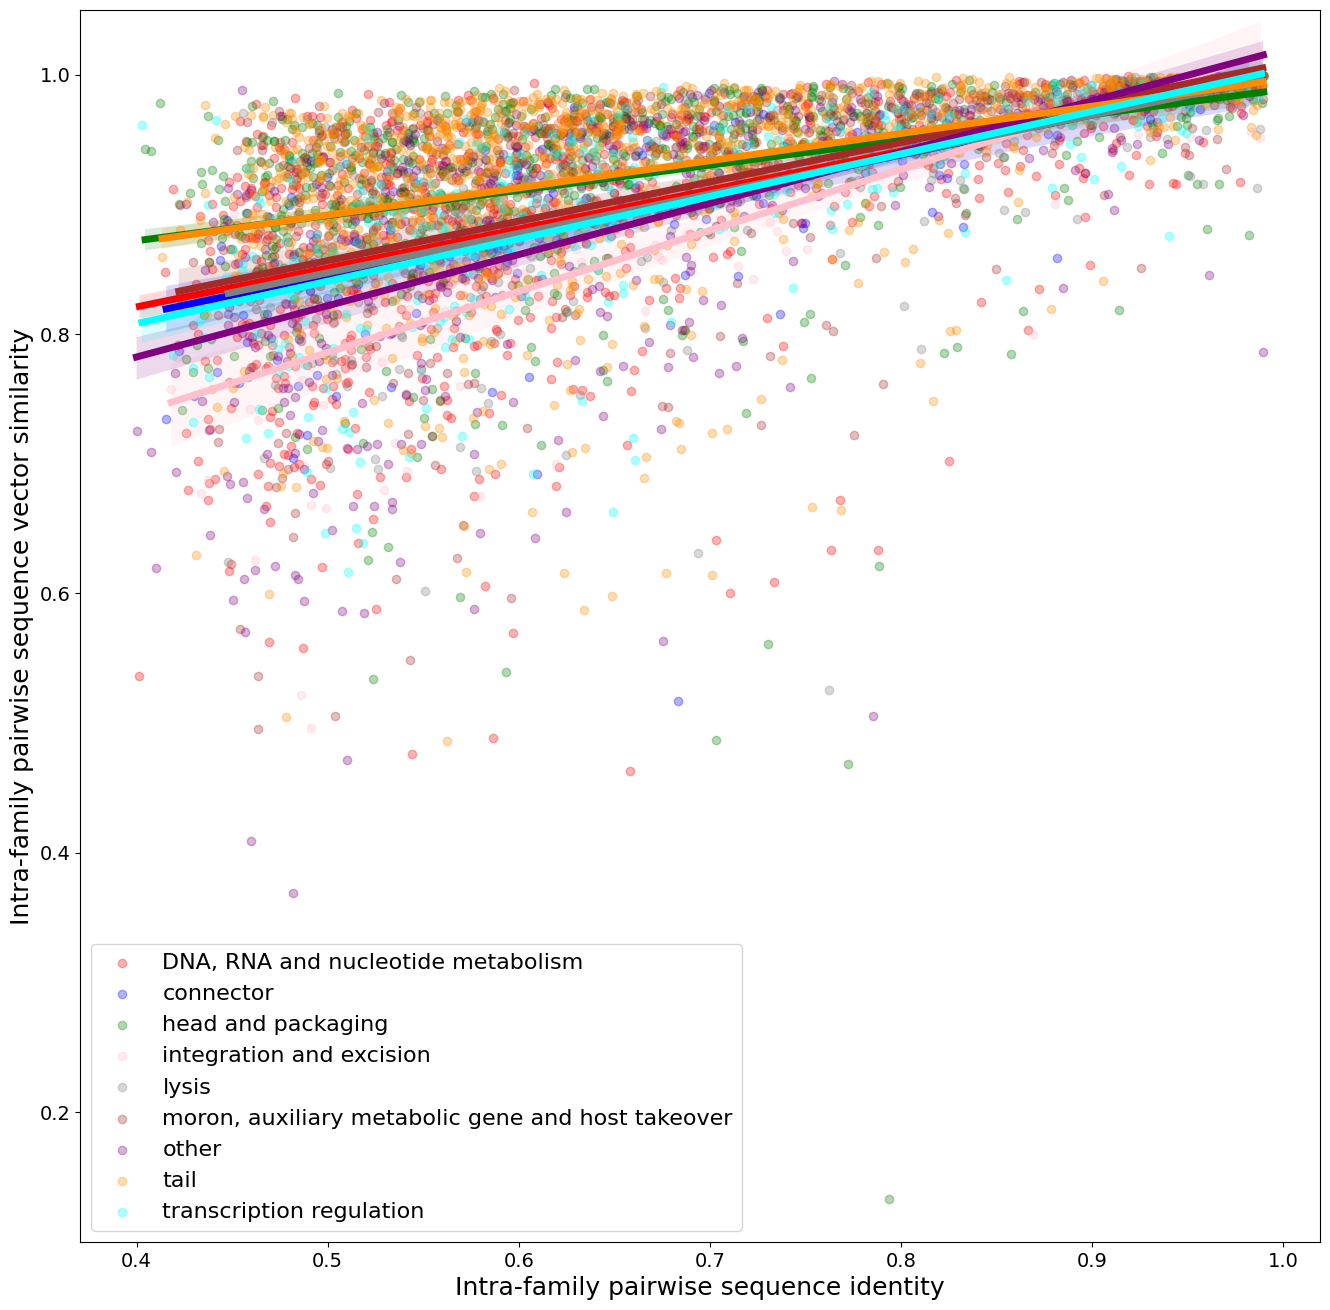

In [31]:
cs = set(df_b['Category'])
lines_real = {}
for c in phrog_palette.keys():
    d = df_b[df_b['Category'] == c]

    ax = sns.regplot(data=d,
                    x='pairwise_mean',
                    y='mean_vector_sim',
                    color=phrog_palette[c],
                    label=c,
                    scatter_kws={'alpha':0.3},
                    line_kws={'linewidth':5})
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        x=d['pairwise_mean'],
        y=d['mean_vector_sim']
    )
    lines_real[c] = (slope, intercept, r_value, p_value, std_err)
    

ax.legend(loc='best', fontsize=16)

plt.ylim([0.10, 1.05])
plt.ylabel('Intra-family pairwise sequence vector similarity', fontsize=18)
plt.xlabel('Intra-family pairwise sequence identity', fontsize=18)
plt.savefig('vector_sim_by_sequence_identitiy.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
cols = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
df_lines = pd.DataFrame.from_dict(lines_real, orient='index', columns=cols).reset_index()

df_lines

,index,slope,intercept,r_value,p_value,std_err
0,"DNA, RNA and nucleotide metabolism",0.300235,0.700769,0.548146,4.200771e-78,0.014634
1,connector,0.308770,0.691004,0.578676,4.514901e-13,0.038314
2,head and packaging,0.194379,0.794113,0.397187,3.222179e-34,0.015253
3,integration and excision,0.470309,0.550593,0.710667,1.210595e-16,0.047031
4,lysis,0.304039,0.695136,0.603704,1.368427e-29,0.023908
5,"moron, auxiliary metabolic gene and host takeover",0.303480,0.704836,0.544743,5.561156e-34,0.022797
6,other,0.394870,0.624289,0.607266,1.011288e-54,0.022483
7,tail,0.209647,0.786859,0.431104,9.396105e-53,0.013013
8,transcription regulation,0.327168,0.677069,0.643536,1.744536e-34,0.023214
